In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from scipy import stats
import json 
import yaml
import os 
import copy
from PIL import Image, ImageEnhance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Parameters

In [2]:
# set a few parameters 
working_dir = os.getcwd()
data_dir = working_dir + '/../' + 'data/'
image_dir = working_dir + '/../' + 'images/'
num_trials = 300
num_subs = 30
num_animals = 306
num_objects = 491

## Functions

In [5]:
def get_data(data_dir,n_max=num_animals):
    ''' parser to import .txt files '''
    files = os.listdir(data_dir)
    # iterate over files and import JSONs
    alldata = {'ratings':[],'domain':'','feature':''}
    ratings = np.empty((n_max,num_subs))
    ratings.fill(np.nan)
    for ii,fname in enumerate(files):
        with open(data_dir + fname,'r') as f:
            data = yaml.load(f,Loader=yaml.FullLoader)
            for jj,rtng in enumerate(data['image_ids']):
                ratings[rtng-1,ii] = data['responses'][jj]
    alldata['ratings'] = ratings
    alldata['image_ids'] = np.arange(1,n_max+1)
    alldata['domain'] = data['stim_domain']
    if data['stim_feature']=='large':
        alldata['feature'] = 'size'
    elif data['stim_feature']=='danger':
        alldata['feature'] = 'dangerousness'
    elif data['stim_feature']=='fast':
        alldata['feature'] = 'speed'
    
    return alldata

def average_data(alldata,method='mode'):
    '''
    averages data across participants with chosen method
    creates five unique bins (from very low to very high)
    returns dataframe with separate columns for each feature

    inputs:
    - alldata: dataset as generated by gen_data()
    - method: averaging technique (mode,mean,median)
    '''
    pass


def hist_ratings(alldata,nbins=5):
    ''' plot distribution of mean ratings '''
    plt.figure(figsize=(10,10))
    # ax= sns.histplot(np.round(np.nanmean(alldata['ratings'],1),2),bins=nbins)
    ax= sns.histplot(stats.mode(alldata['ratings'],1)[0],bins=nbins,legend=False)
    sns.despine()
    ax.set(xlabel='rating',ylabel='number of stimuli',title='Avg Ratings (mode), ' + alldata['domain'] + ' - ' + alldata['feature'])


def hist_stddev(alldata,nbins=15):
    ''' plot distribution of rating consistency'''
    plt.figure(figsize=(10,10))
    ax= sns.histplot(np.round(np.nanstd(alldata['ratings'],1),2),bins=nbins)
    sns.despine()
    ax.set(xlabel='std',ylabel='number of stimuli',title='Rating variability, ' + alldata['domain'] + ' - ' + alldata['feature'])


def disp_4x5grid(image_ids,alldata,lvl='very low'):
    plt.figure(figsize=(12,7))
    plt.suptitle(alldata['domain'] + '-' + alldata['feature'] + ': ' + lvl)
    for ii,im in enumerate(image_ids):
        # load image 
        with Image.open(image_dir + alldata['domain'] + str(im) + '.png') as im:
            img = np.asarray(im)
        plt.subplot(4,5,ii+1)
        plt.imshow(img)
        ax = plt.gca()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')

def disp_samples_perbin(data,feature='dangerousness'):
    if feature=='dangerousness':
        levels = ['very low','low','medium','high','very high']
    elif feature=='size':
        levels = ['very small','small','medium','large','very large']
    elif feature=='speed':
        levels = ['very slow', 'slow','medium','fast','very fast']
    
    # take mode across participants 
    mean_ratings_all = stats.mode(data['ratings'],1)[0].ravel()
    # obtain bin ids 
    bin_idces = bin_data(mean_ratings_all)
    # loop over levels, create a single figure per level 
    for lvl in range(5):
        image_ids = data['image_ids'][bin_idces==lvl+1]
        # sample images (not more than I have in smallest bin)
        image_ids = np.random.choice(image_ids,np.bincount(bin_idces)[1:].min(),replace=False)
        disp_4x5grid(image_ids,data,lvl=levels[lvl])




def bin_data(data,nbins=5):
    ''' assigns bin indices to each element of the input array'''
    idces = np.zeros(len(data))
    # compute boudaries
    bounds = np.linspace(min(data),max(data),nbins+1)
    for ii in range(0,nbins):
        idces[(data>bounds[ii]) & (data <= bounds[ii+1])] = ii+1
    idces = idces.astype('int')
    idces[idces==0] = 1
    return idces
        



def whiteToAlpha(img):
	""" renders white background of image transparent
	 found under http://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent """
	img   = img.convert("RGBA")
	datas =       img.getdata()

	newData = []
	for item in datas:
		if item[0] > 250 and item[1] > 250 and item[2] > 250: # i.e. pixel is 'white' [changed, thresh was 100]
			newData.append((255,255,255,0)) # adds zero opacity
		else:
			newData.append(item)
	img.putdata(newData)
	return img

### Analysis plan
Goal: discretise animals distribution into five levels of subjective dangerousness   
Caveats:   
- distribution of ratings (uniform would be ideal)
- inter-subject consistence of ratings 

Approach:
Question 1: what is the average dangerousness rating of animals?
- create ordered animal-x-subject matrix of ratings 
- plot histogram of mean and median ratings (how many avg ratings per level of dangerousness?)
- subplots with sample images for each level   


Question 2: How consistent are the ratings?
- plot histogram of variance in rating (hopefully low on average)
- plot animals with most and least consistent ratings 
- set consistency cutoff 
- subplots with sample images for each level after removal of less consistent images 



## Import raw data

In [6]:
data_ad = get_data(data_dir + 'animals_dangerousness/')
data_as = get_data(data_dir + 'animals_size/')
data_af = get_data(data_dir + 'animals_speed/')


### EDA

In [145]:
%matplotlib qt
# Distribution of average ratings
hist_ratings(data_ad,nbins=5)
hist_ratings(data_as,nbins=5)

In [56]:
ax = plt.gca()
ax.set_xticks(np.arange(1,6))

In [44]:
# distribution of rating standard deviation
hist_stddev(alldata)

#### Insights:
- The distribution of ratings is highly right-skewed: most animals received a low dangerousness rating.  
- The distribution of rating standard deviations is normal with a mean of 0.7. 


Ideally, our ratings are consistent across subjects, i.e. assigned ratings are highly reliable. Let's perform a median split on low and high variance ratings and look at the distribution of average ratings.

In [58]:
# median split of all ratings 
variances = np.nanstd(data_as['ratings'],1)
cutoff = np.median(variances)
data_as_low = copy.deepcopy(data_as)
data_as_low['ratings'] = data_as['ratings'][variances<cutoff,:]
data_as_high = copy.deepcopy(data_as)
data_as_high['ratings'] = data_as['ratings'][variances>=cutoff,:]

In [61]:
hist_ratings(data_as_low,nbins=5)

The ratings for the extremes are very consistent. Participants disagree more about medium than low or high dangerousness levels  
Let's look at a custom cutoff of sigma=1

In [117]:
cutoff = 1
data_as_low = copy.deepcopy(data_as)
data_as_low['ratings'] = data_as['ratings'][variances<cutoff,:]
hist_ratings(data_as_low,nbins=5)

In [118]:
# divide ratings into five discrete bins 
mean_ratings_all  = stats.mode(data_as['ratings'],1)[0].ravel()
mean_ratings_clean = stats.mode(data_as_low['ratings'],1)[0].ravel()
# count stimuli per rating 
count_all = np.histogram(mean_ratings_all,bins=5)[0]
count_clean = np.histogram(mean_ratings_clean,bins=5)[0]
print('Items per bin, raw data: {} \n\nItems per bin, cleaned data: {}'.format(count_all,count_clean))

Items per bin, raw data: [ 58 102  49  81  16] 

Items per bin, cleaned data: [ 58 102  48  81  16]


In [99]:
# binidces = np.digitize(mean_ratings_clean,bins=np.linspace(min(mean_ratings_clean),max(mean_ratings_clean),6),right=True)
# np.bincount(binidces)

In [111]:
        
idces = bin_data(mean_ratings_all)
print(np.bincount(idces)[1:])
print(np.unique(idces))

[ 58 102  49  81  16]
[1 2 3 4 5]


# Sample Images for each rating

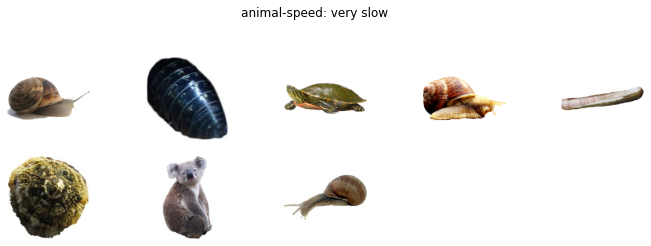

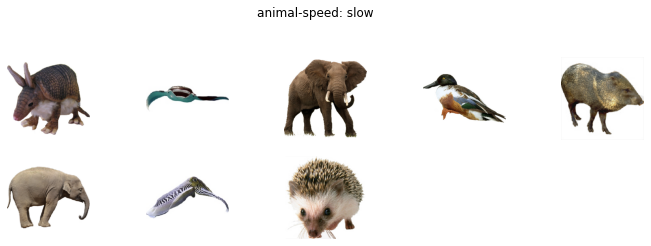

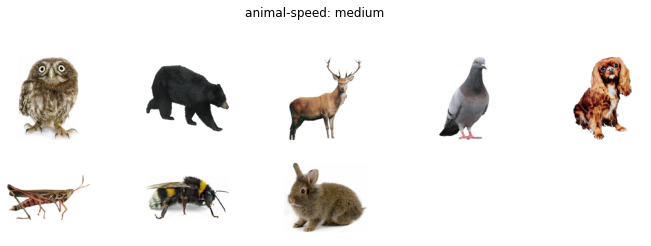

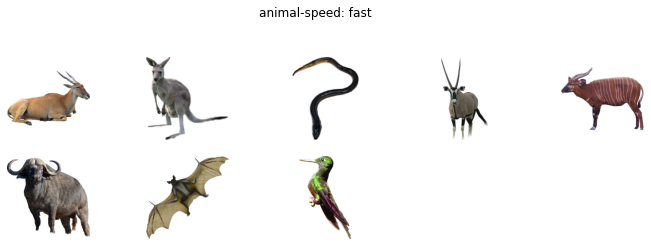

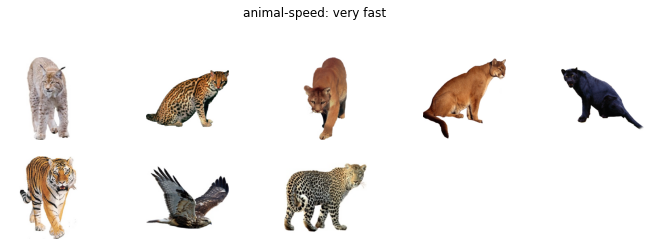

In [59]:
# display samples for dangerousness 
# disp_samples_perbin(data_ad,feature=data_ad['feature'])

# display samples for size 
# disp_samples_perbin(data_as, feature=data_as['feature'])

# display samples for speed
disp_samples_perbin(data_af, feature=data_af['feature'])


# Distribution of Modes

[Text(0.5, 0, 'rating'),
 Text(0, 0.5, 'number of stimuli'),
 Text(0.5, 1.0, 'Avg Ratings (mode), animal - size')]

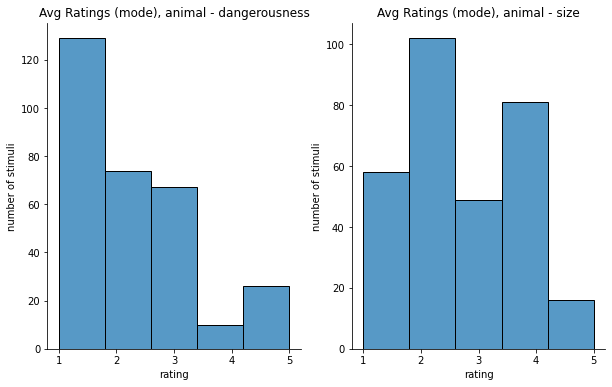

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
ax= sns.histplot(stats.mode(data_ad['ratings'],1)[0],bins=5,legend=False)
sns.despine()
ax.set(xlabel='rating',ylabel='number of stimuli',title='Avg Ratings (mode), ' + data_ad['domain'] + ' - ' + data_ad['feature'])

plt.subplot(1,2,2)
ax= sns.histplot(stats.mode(data_as['ratings'],1)[0],bins=5,legend=False)
sns.despine()
ax.set(xlabel='rating',ylabel='number of stimuli',title='Avg Ratings (mode), ' + data_as['domain'] + ' - ' + data_as['feature'])



# Reliability of ratings

In [110]:
%matplotlib qt
plt.figure(figsize=(10,5))
# dangerousness
plt.subplot(1,3,1)
m,c = stats.mode(data_ad['ratings'],1)
df = pd.DataFrame(np.concatenate((m,c),axis=1),columns=['mode','count'])
# sns.set_palette("crest")
sns.histplot(data=df,x='count',hue='mode',palette='crest',element='step',kde=True,alpha=.7)
sns.despine()
ax = plt.gca()
ax.set_ylabel('number of ratings')
ax.set_xlabel('number of subjects')
ax.set_title('animal - dangerousness')
ax.set_xlim((1,30))

# size
plt.subplot(1,3,2)
m,c = stats.mode(data_as['ratings'],1)
df = pd.DataFrame(np.concatenate((m,c),axis=1),columns=['mode','count'])
# sns.set_palette("crest")
sns.histplot(data=df,x='count',hue='mode',palette='crest',element='step',kde=True,alpha=.7)
sns.despine()
ax = plt.gca()
ax.set_ylabel('number of ratings')
ax.set_xlabel('number of subjects')
ax.set_title('animal - size')
ax.set_xlim((1,30))

# speed 
plt.subplot(1,3,3)
m,c = stats.mode(data_af['ratings'],1)
df = pd.DataFrame(np.concatenate((m,c),axis=1),columns=['mode','count'])
# sns.set_palette("crest")
sns.histplot(data=df,x='count',hue='mode',palette='crest',element='step',kde=True,alpha=.7)
sns.despine()
ax = plt.gca()
ax.set_ylabel('number of ratings')
ax.set_xlabel('number of subjects')
ax.set_title('animal - speed')
ax.set_xlim((1,30))

(1.0, 30.0)

# Scatterplot of feature space

In [7]:
# create dataset with all features
features = np.concatenate((stats.mode(data_ad['ratings'],1)[0],stats.mode(data_as['ratings'],1)[0],stats.mode(data_af['ratings'],1)[0]),axis=1)
image_ids = ['animal' + str(ii) + '.png' for ii in range(1,num_animals+1)]
df = pd.DataFrame(features,columns=['dangerousness','size','speed'])
df['image ids'] = image_ids
df.head()

,dangerousness,size,speed,image ids
0,3.0,3.0,3.0,animal1.png
1,2.0,2.0,4.0,animal2.png
2,3.0,4.0,3.0,animal3.png
3,1.0,2.0,2.0,animal4.png
4,2.0,5.0,3.0,animal5.png


In [114]:
corrs = df.corr('kendall')
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask,k=1)] = True
sns.heatmap(corrs,annot=True,fmt='.2f',square=True, mask=mask,vmin=0,vmax=1,linewidth=2)


<AxesSubplot:>

In [113]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
plt.figure(figsize=(15,15))
g = sns.pairplot(df)
g.map_upper(hide_current_axis)
# plt.suptitle(str(stats.spearmanr(df[['dangerousness']].to_numpy(),df[['size']].to_numpy())))
plt.tight_layout()

In [84]:
x,y = np.meshgrid(np.arange(2,6,2),np.arange(2,8,2))
for idx in zip(np.arange(6),x.flatten(),y.flatten()):
    print(idx)

(0, 2, 2)
(1, 4, 2)
(2, 2, 4)
(3, 4, 4)
(4, 2, 6)
(5, 4, 6)


In [35]:
%matplotlib qt
f,ax = plt.subplots(nrows=5,ncols=5,figsize=(15,15),dpi=200)
for xi in range(5):
    for yi in range(5):
        image_ids = df['image ids'][df.index[(df['size']==xi+1) & (df['speed']==yi+1)]].tolist()
        if len(image_ids):
            # sample only max 6 images per category
            n_items = np.min([len(image_ids),4])
            idcs = np.random.permutation(len(image_ids))            
            image_ids = np.asarray(image_ids)[idcs]
            imgs = image_ids[:n_items]
            for ii in imgs:
                im =  Image.open(image_dir + ii)
                im.convert('RGBA')
                im = whiteToAlpha(im)
                img = OffsetImage(np.asarray(im),zoom=0.1)
                ab = AnnotationBbox(img,(.5+np.random.randn()*2.5,.5+np.random.randn()*2.5),frameon=False)
                ax[xi,yi].add_artist(ab)
        ax[xi,yi].set_xlim((-9,9))
        ax[xi,yi].set_ylim((-9,9))
        ax[xi,yi].set_xticks([])
        ax[xi,yi].set_yticks([])
        

In [33]:
np.asarray(image_ids)[idcs]


array(['animal263.png', 'animal260.png', 'animal261.png', 'animal97.png',
       'animal225.png', 'animal43.png', 'animal285.png', 'animal232.png',
       'animal240.png', 'animal220.png', 'animal231.png', 'animal259.png',
       'animal233.png', 'animal258.png', 'animal234.png', 'animal239.png'],
      dtype='<U13')